# movie_tp

## Visualize BOLD time series

In [2]:
import sys, os
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import re
import seaborn as sns

In [3]:
csv_path = "./Movie_ROI/movie_tp/sub-NDARAG115LZP_ROI114.csv" 
df = pd.read_csv(csv_path)
roi = df.to_numpy(dtype=np.float32).T
print(roi.shape)

def load_roi_cube(
    folder: str,
    pattern: str = "sub-*_ROI114.csv",
    n_roi: int = roi[0].shape,
    t_len: int = roi[1].shape,
    dtype=np.float32,
):
    folder = Path(folder)
    files = sorted(folder.glob(pattern))
    if not files:
        raise FileNotFoundError(f"No files matched: {folder / pattern}")

    arrays = []
    subject_ids = []

    for fp in files:
        df = pd.read_csv(fp)
        arr = df.to_numpy(dtype=dtype)
        arr = arr.T           
        arr = np.nan_to_num(arr)
        arrays.append(arr)

        m = re.search(r"sub-([A-Za-z0-9]+)", fp.name)
        subject_ids.append(m.group(1) if m else fp.stem)

    roi_all = np.stack(arrays, axis=0)  # (num_subjects, 114, 239)
    return roi_all, subject_ids

root_dir = "./Movie_ROI/movie_tp"
roi_all, subject_ids = load_roi_cube(root_dir)

print("roi_all shape:", roi_all.shape)       
print("num_subjects:", len(subject_ids))
print("first 3 subjects:", subject_ids[:3])


(114, 239)
roi_all shape: (87, 114, 239)
num_subjects: 87
first 3 subjects: ['NDARAG115LZP', 'NDARAU967RWU', 'NDARBH133TK6']


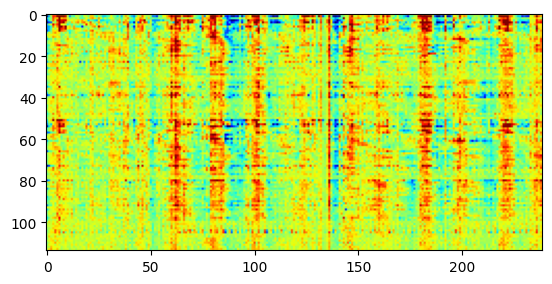

In [14]:
plt.imshow(roi_all[3], cmap="jet", vmin=-3, vmax=2)
# plt.colorbar()

Total data size: (87, 114, 239)
(114,)
Stable ROI IDs: [107 101 102 108 109]
Dynamic ROI IDs: [71 40 81 90 17]


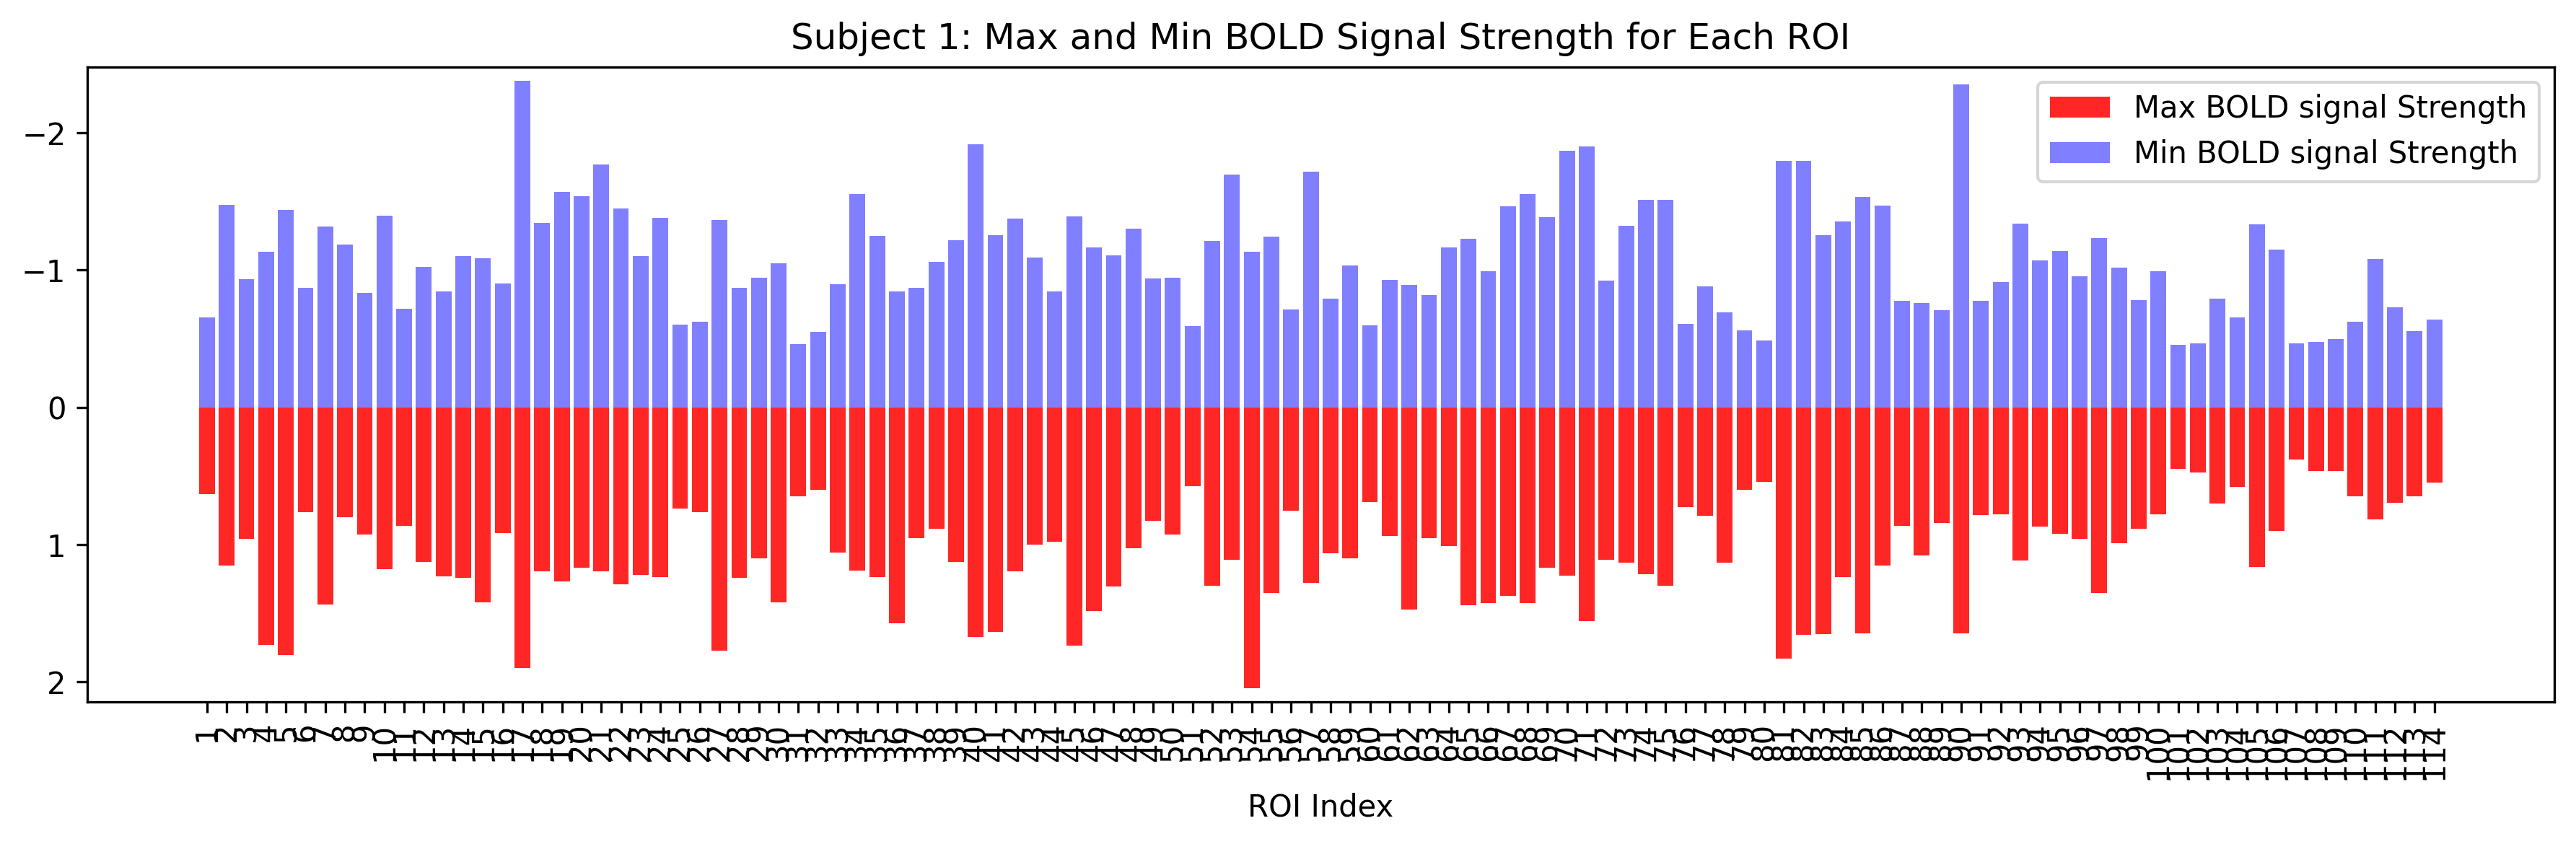

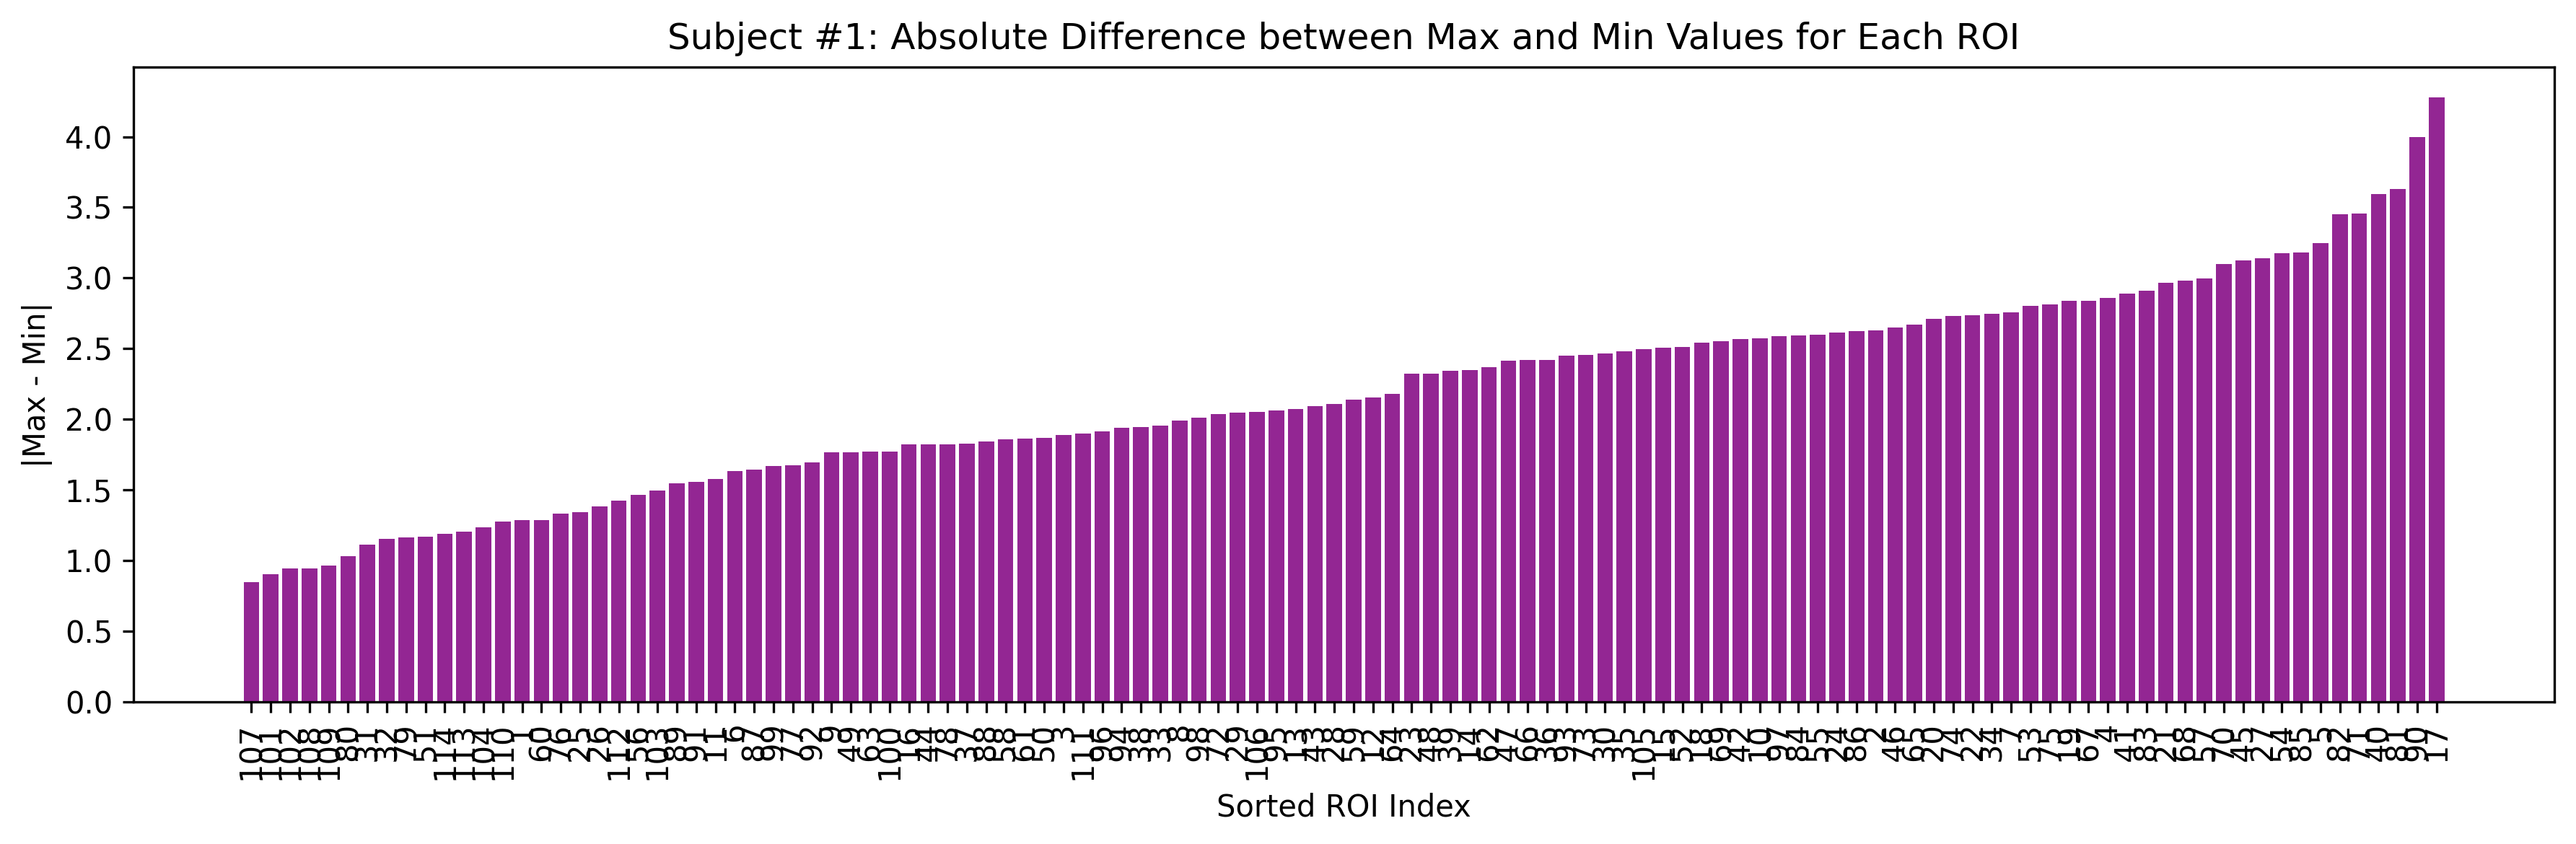

In [25]:
print('Total data size:', roi_all.shape)
plt.figure(figsize=[12, 4], dpi=300)
max_vals =np.array([roi_all[0][i].max() for i in range(114)])
min_vals =np.array([roi_all[0][i].min() for i in range(114)])
plt.bar(np.arange(114), max_vals, color='red', alpha=0.85)
plt.bar(np.arange(114), min_vals, color='blue', alpha=0.5)
plt.xticks(np.arange(114), np.arange(1, 115), rotation=90)
plt.xlabel('ROI Index')
plt.legend(['Max BOLD signal Strength', 'Min BOLD signal Strength'])
plt.ylim([max_vals.max()+.1, min_vals.min()-.1])
plt.title(f'Subject 1: Max and Min BOLD Signal Strength for Each ROI')
plt.tight_layout()
plt.savefig(f"sub_1_1", dpi=300)

# Calculate the absolute difference between max and min values for each ROI's BOLD signal
abs_diff = np.abs(np.array(max_vals) - np.array(min_vals))
print(abs_diff.shape)
# Sort the absolute differences and get the sorted indices
sorted_indices = np.argsort(abs_diff)

# Plot the sorted absolute differences
plt.figure(figsize=[12, 4], dpi=300)
plt.bar(np.arange(len(abs_diff)), abs_diff[sorted_indices], color='purple', alpha=0.85)
plt.xticks(np.arange(len(abs_diff)), sorted_indices + 1, rotation=90)
plt.xlabel('Sorted ROI Index')
plt.ylabel('|Max - Min|')
plt.title(f'Subject #1: Absolute Difference between Max and Min Values for Each ROI')
plt.tight_layout()
plt.savefig(f"sub_1_2", dpi=300)


print('Stable ROI IDs:', sorted_indices[:5]+1)
print('Dynamic ROI IDs:', sorted_indices[-5:]+1)

### ROI-level BOLD signals across 6 different subjects


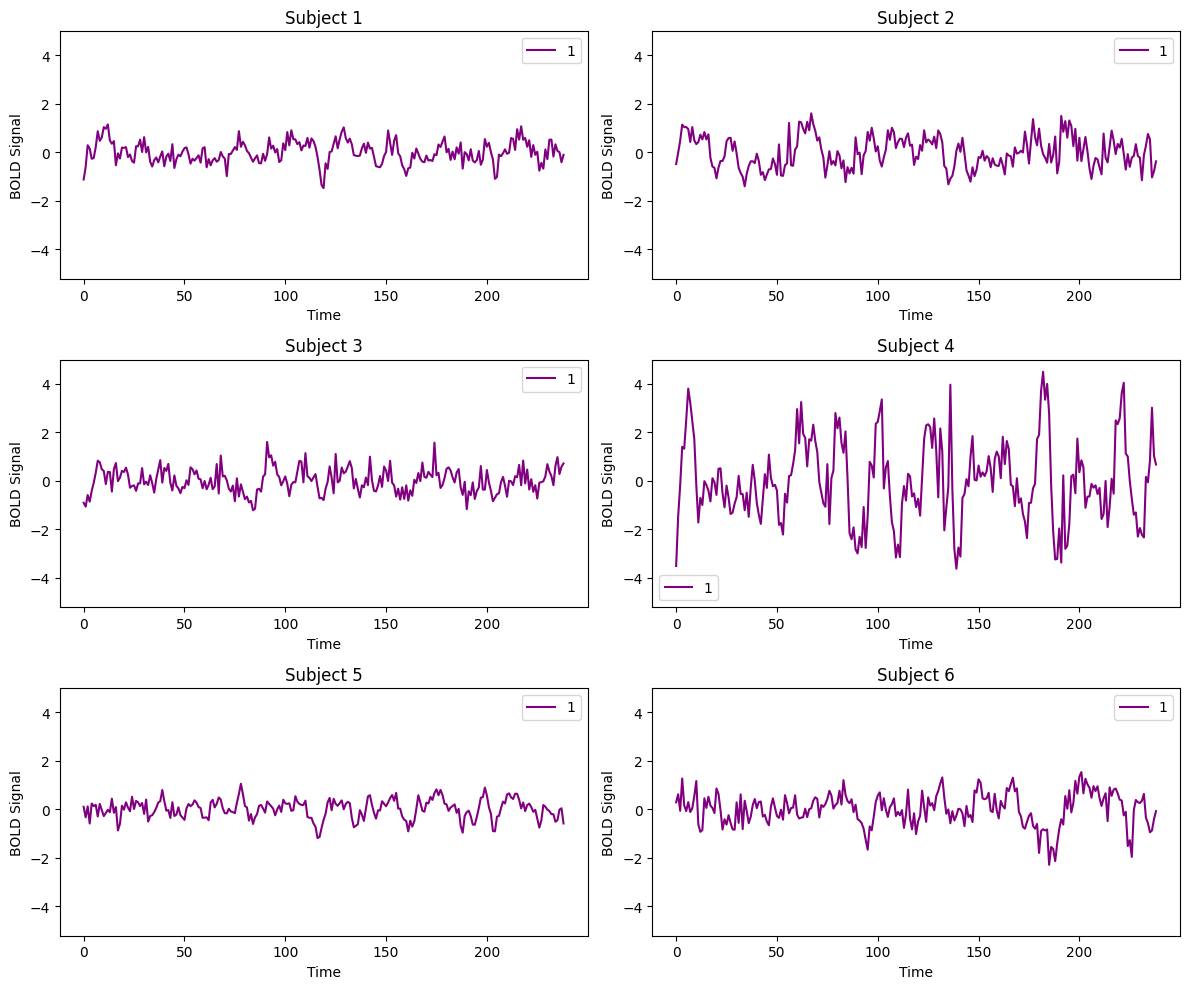

In [11]:
global_min = np.min([d.min() for d in roi_all[:6]])
global_max = np.max([d.max() for d in roi_all[:6]])

plt.figure(figsize=[12,10],dpi = 100)
r_id = 1 # roi index    

for sub_id in range(6): #  6 subjects
    reshaped_data = roi_all[sub_id].T    # (239,114)
    plt.subplot(3,2,sub_id+1)
    plt.plot(reshaped_data[:,r_id], 'purple')
    plt.ylim(global_min-.5, global_max+.5) # normalize y-range
    plt.xlabel('Time')
    plt.ylabel('BOLD Signal')
    plt.title(f'Subject {sub_id+1}')
    plt.legend([f'{r_id}'])
plt.tight_layout()
plt.savefig(f"roi_{r_id}", dpi=300)

### Visualize Subject-level BOLD signals

(87, 114, 239)


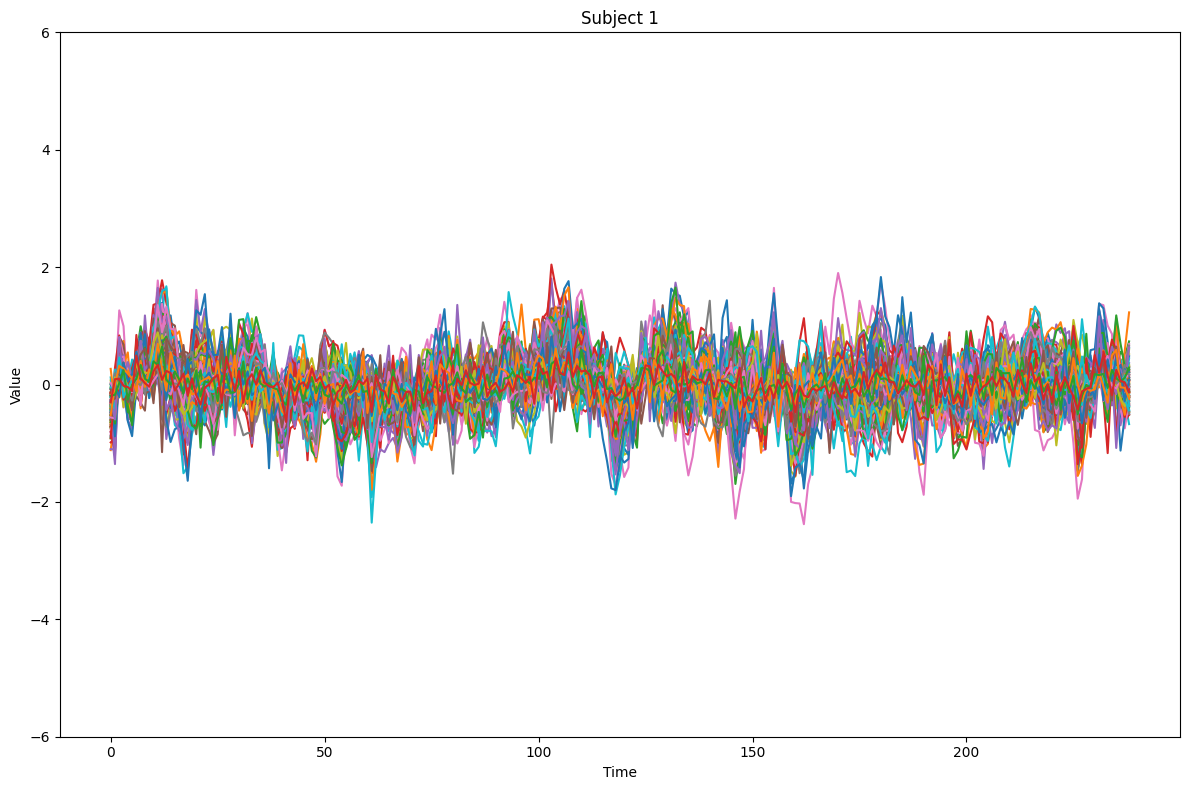

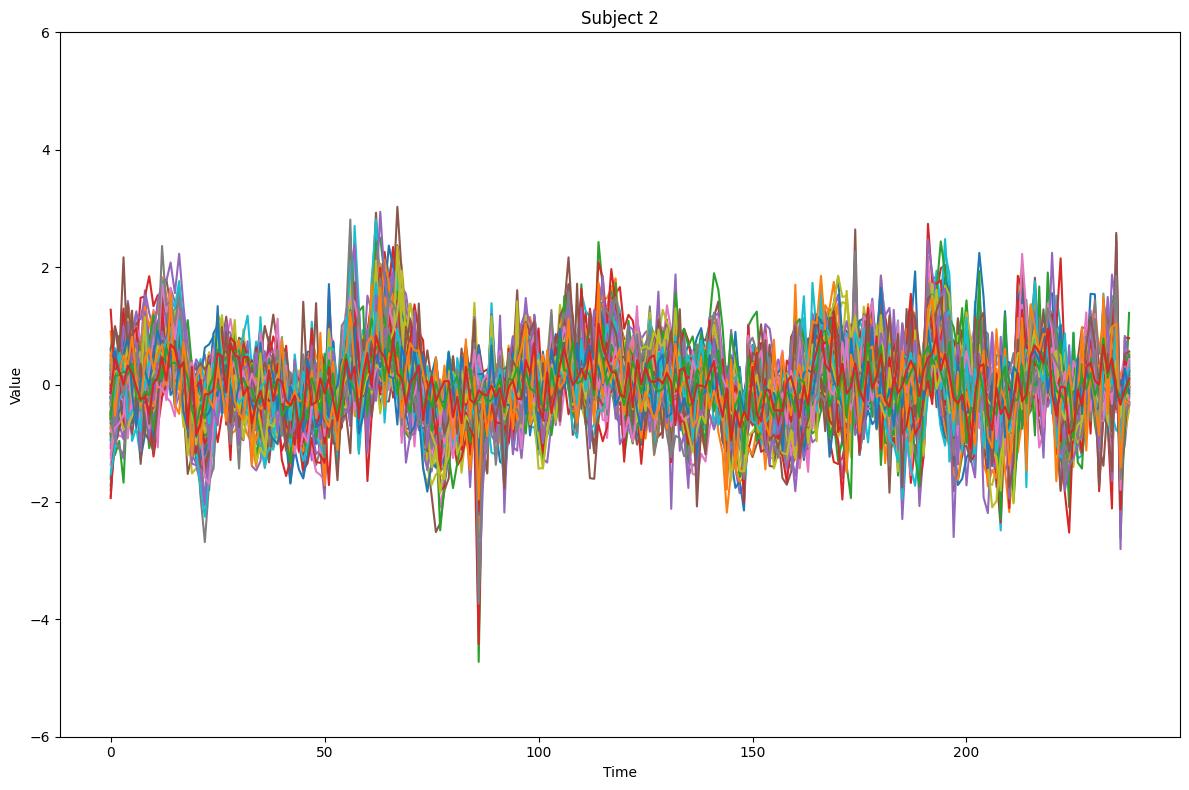

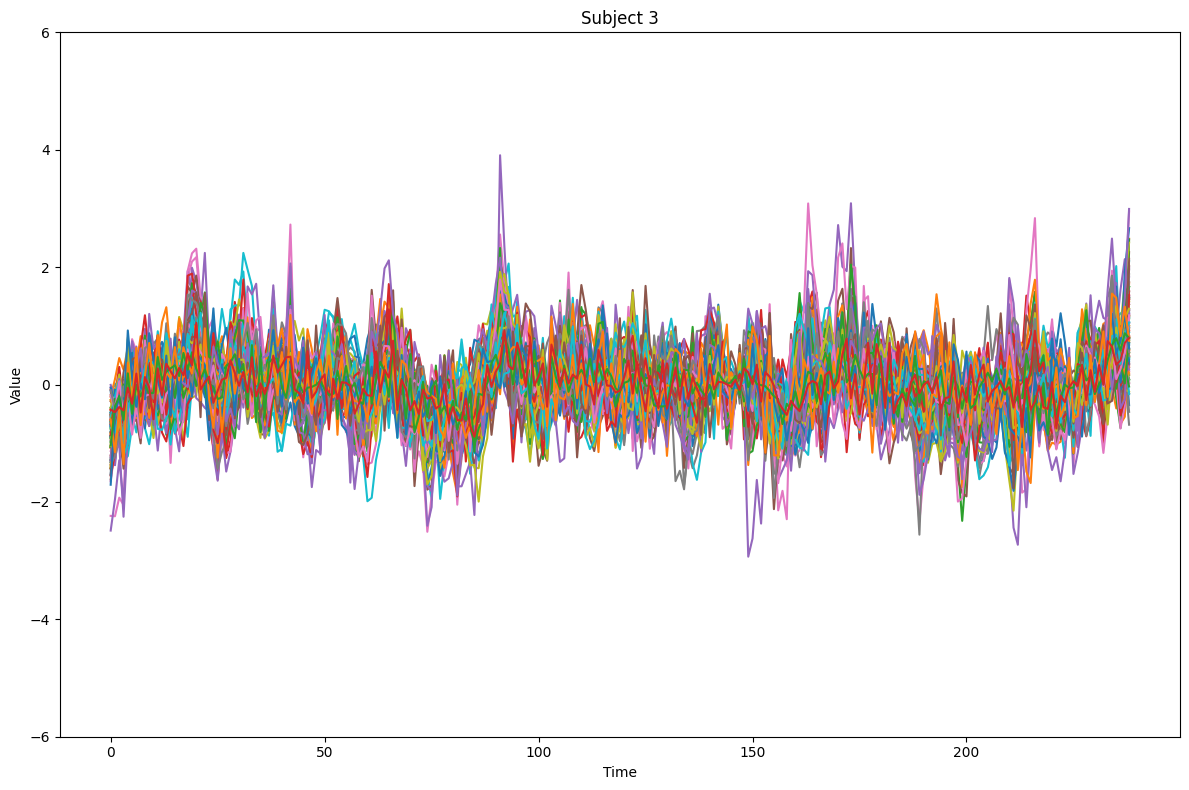

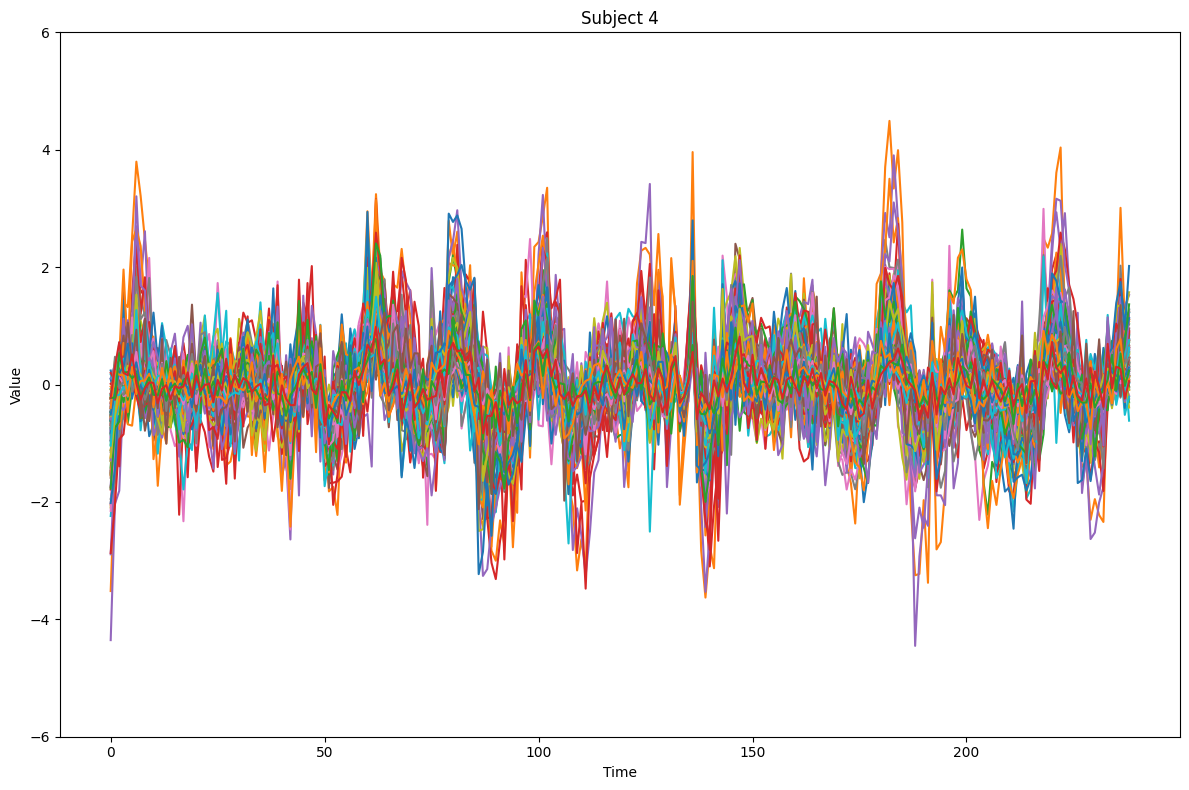

In [20]:
def plot_subject_fMRI_data(sub_id, ts_data):
    plt.figure(figsize=(12, 8))
    for i in range(ts_data[sub_id].shape[0]):
        sns.lineplot(data=ts_data[sub_id][i])
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.ylim([-6, 6])
    plt.title(f'Subject {sub_id+1}')
        
    plt.tight_layout()
    plt.savefig(f"Subject_{sub_id+1}", dpi=300)

# roi_all: [87,114,239]
print(roi_all.shape)
plot_subject_fMRI_data(0, roi_all)
plot_subject_fMRI_data(1, roi_all)
plot_subject_fMRI_data(2, roi_all)
plot_subject_fMRI_data(3, roi_all)

## Visualize functional connectivity matrices for each subject

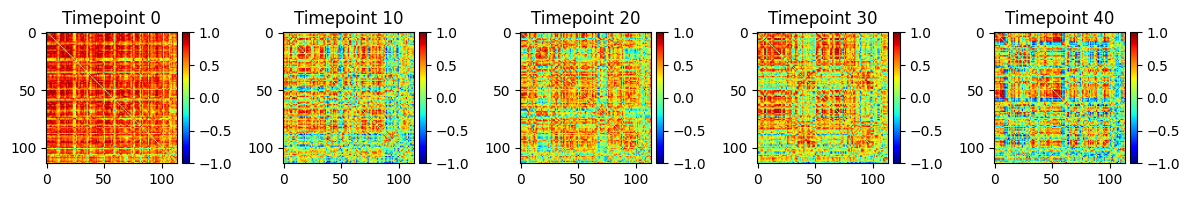

In [32]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

def compute_temporal_graphs(ts_data, subject_idx=0, window_size=20, step_size=5):

    subject_data = ts_data[subject_idx]  # Shape: [regions, timepoints]
    total_timepoints = subject_data.shape[1]

    # Normalize time series to avoid zero correlation issues
    subject_data = (subject_data - np.mean(subject_data, axis=1, keepdims=True)) / np.std(subject_data, axis=1, keepdims=True)

    # Compute the correct number of graphs
    num_graphs = (total_timepoints - window_size) // step_size + 1
    FC_mats = np.zeros((subject_data.shape[0], subject_data.shape[0], num_graphs))

    graphs = []
    graph_idx = 0
    for start in range(0, total_timepoints - window_size + 1, step_size):
        window = subject_data[:, start:start + window_size]  # Shape: [regions, window_size]

        # Compute functional connectivity (Pearson correlation) correctly
        corr_matrix = np.corrcoef(window, rowvar=True)  # Correlation across regions
        np.fill_diagonal(corr_matrix, 0)  # Remove self-connections

        FC_mats[:, :, graph_idx] = corr_matrix  # Store at correct index

        # Create a graph
        G = nx.from_numpy_array(corr_matrix)
        graphs.append(G)

        graph_idx += 1

    return graphs, FC_mats

def visualize_fc_matrices(FC_mats, SS):
    """Visualize functional connectivity matrices for selected timepoints with adjusted color bar length."""
    plt.figure(figsize=(12, 6))
    num_plots = len(SS)
    for s, timepoint in enumerate(SS):
        ax = plt.subplot(1, num_plots, s + 1)
        im = ax.imshow(FC_mats[:, :, timepoint], cmap='jet', vmin=-1, vmax=1)
        ax.set_title(f'Timepoint {timepoint}')

        # Adjust color bar to match graph size
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)

    plt.tight_layout()
    plt.savefig(f"sub_1_fc", dpi=300)
    plt.show()

temporal_graphs, FC_mats = compute_temporal_graphs(roi_all, subject_idx=0, window_size=10, step_size=5)
visualize_fc_matrices(FC_mats,[0,10,20,30,40])

### TEA plot and average novelty

In [33]:
import numpy as np
import networkx as nx

def compute_binary_temporal_graphs(FC_mats, threshold=0.1):

    binary_matrices = []

    for i in range(FC_mats.shape[2]):  # Iterate over time points
        correlation_matrix = FC_mats[:, :, i]

        # Convert to binary adjacency matrix using the threshold
        # binary_matrix = (np.abs(correlation_matrix) > threshold).astype(int) # 36830, 34270, 37662
        binary_matrix = (correlation_matrix > threshold).astype(int) # 35730, 33668, 36178

        # Store binary matrix
        binary_matrices.append(binary_matrix)

    return np.array(binary_matrices)

binary_temporal_graphs = compute_binary_temporal_graphs(FC_mats, threshold=0.4)
print(len(binary_temporal_graphs), binary_temporal_graphs.shape)

46 (46, 114, 114)


In [29]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.interpolate import make_interp_spline

def compute_novelty_index(dynfc_matrices):
    novelty_indices = []
    seen_edges = set()

    for matrix in dynfc_matrices:
        current_graph = nx.from_numpy_array(matrix)
        current_edges = set(current_graph.edges())

        new_edges = current_edges - seen_edges
        total_edges = len(current_edges)

        novelty_index = len(new_edges) / total_edges if total_edges > 0 else 0
        novelty_indices.append(novelty_index)
        seen_edges.update(current_edges)

    average_novelty_index = np.mean(novelty_indices) if novelty_indices else 0

    return novelty_indices, average_novelty_index

def plot_tea_plot(dynfc_matrices_list, session_idx, thresholds):
    fig, axes = plt.subplots(3, 2, figsize=(18, 12))
    
    for idx, (threshold, dynfc_matrices) in enumerate(zip(thresholds, dynfc_matrices_list)):
        row, col = divmod(idx, 2)
        graph_list = [nx.from_numpy_array(matrix) for matrix in dynfc_matrices]

        repeated_edges = [0]
        new_graph = nx.Graph()
        for i in range(1, len(graph_list)):
            new_graph = nx.compose(new_graph, graph_list[i-1])
            repeated_edges.append(nx.intersection(new_graph, graph_list[i]).number_of_edges())

        num_edges = [np.count_nonzero(matrix) // 2 for matrix in dynfc_matrices]
        new_edges = [num_edges[i] - repeated_edges[i] for i in range(len(num_edges))]
        novelty_indices, average_novelty_index = compute_novelty_index(dynfc_matrices)

        repeated_edges[0] = 0
        new_edges[0] = num_edges[0]

        ax1 = axes[row, col]
        x_vals = np.arange(len(repeated_edges))
        ax1.bar(x_vals, repeated_edges, color='#1f77b4', alpha=0.8, width=0.8, label="Repeated Edges")
        ax1.bar(x_vals, new_edges, bottom=repeated_edges, color='#ff7f0e', alpha=0.8, width=0.8, label="New Edges")
        ax1.set_xlabel('Time', fontsize=12)
        ax1.set_ylabel('Number of Edges', fontsize=12)
        ax1.legend(loc='upper left', fontsize=10)
        ax1.set_title(f'Threshold: {threshold} (Avg. Novelty: {average_novelty_index:.2f})', fontsize=14)
        ax1.grid(axis='y', linestyle='--', alpha=0.6)
        
        ax3 = ax1.twinx()
        ax3.spines['right'].set_position(('outward', 10))
        
        # Smoothing the novelty index curve with a thinner red color
        if len(x_vals) > 1:
            x_smooth = np.linspace(x_vals.min(), x_vals.max(), 300)
            novelty_smooth = make_interp_spline(x_vals, novelty_indices, k=3)(x_smooth)
            ax3.plot(x_smooth, novelty_smooth, color='red', linestyle='-', linewidth=1.2, label="Novelty Index")
        else:
            ax3.plot(x_vals, novelty_indices, color='red', linestyle='-', linewidth=1.2, label="Novelty Index")
        
        ax3.set_ylabel('Novelty Index', fontsize=12, color='red')
        ax3.tick_params(axis='y', labelcolor='red')
        ax3.legend(loc='lower right', fontsize=10)
    
    plt.tight_layout()
    plt.savefig("TEA1.png", dpi=300, bbox_inches='tight')
    plt.show()


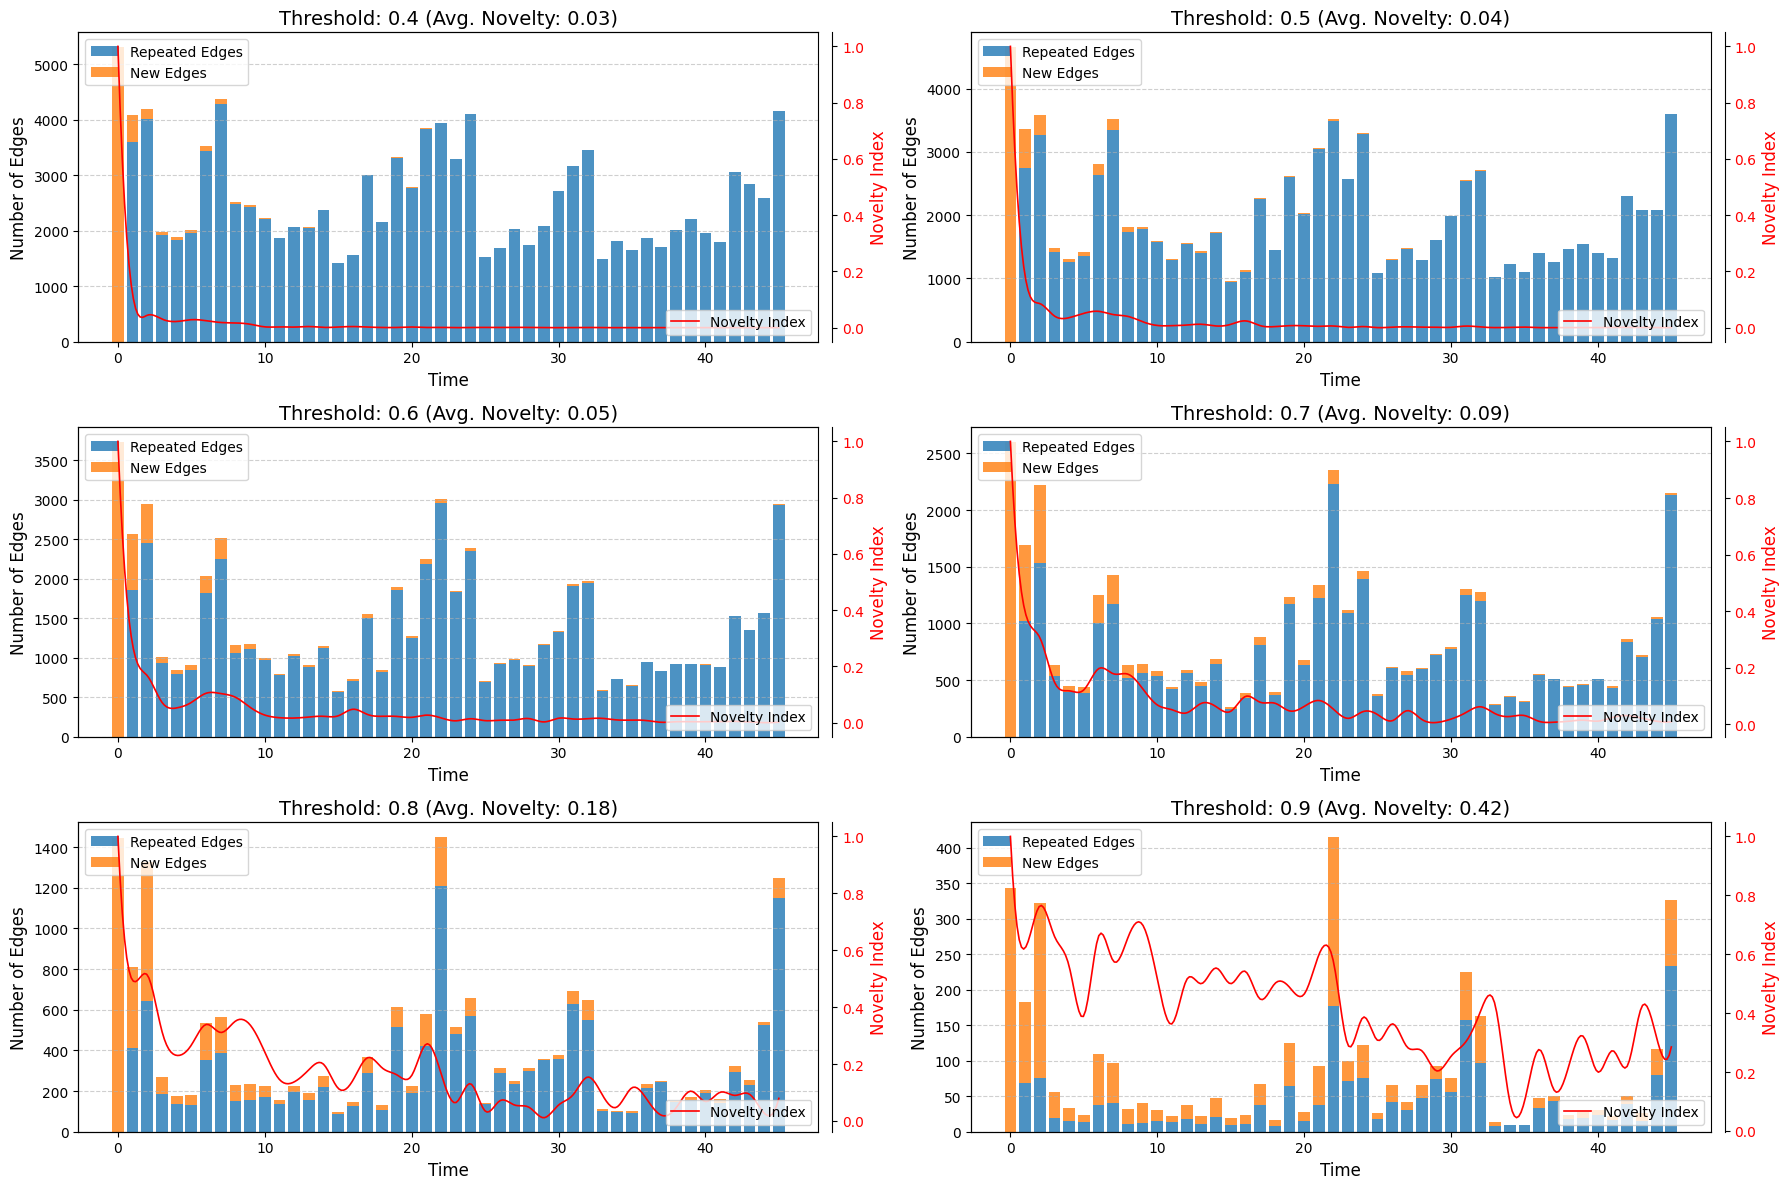

In [36]:
thresh_list = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
binary_temporal_graphs_list = []
for i in range(len(thresh_list)):
    binary_temporal_graphs_list.append(compute_binary_temporal_graphs(FC_mats, thresh_list[i]))
plot_tea_plot(binary_temporal_graphs_list, 0, thresh_list)

## Rating_ToM

In [26]:
import numpy as np
import pandas as pd
from pathlib import Path
from io import StringIO

def _read_second_rating_block(csv_path: str) -> np.ndarray:

    with open(csv_path, "r", encoding="utf-8-sig") as f:
        lines = f.readlines()

    start = None
    for i, ln in enumerate(lines):
        if "%%%%%%" in ln:
            start = i + 1
            break

    numeric_text = "".join(lines[start:])
    df = pd.read_csv(StringIO(numeric_text), header=None, names=["Second", "Rating"])
    df = df.apply(pd.to_numeric, errors="coerce").dropna()
    mat = df[["Second", "Rating"]].to_numpy(dtype=np.float32)  # (N, 2)
    return mat

def load_tp_all_subjects(
    root_dir: str,
    target_file_pattern: str = "S01-TP.csv",  
    strict_same_length: bool = True,         
    pad_value: float = np.nan,                
):
    root = Path(root_dir)
    paths = sorted(root.glob(f"*/{target_file_pattern}"))
    if not paths:
        raise FileNotFoundError(f"no {root}/*/{target_file_pattern}")

    mats = []
    subjects = []
    lengths = []
    for p in paths:
        mat = _read_second_rating_block(str(p))  # (N, 2)
        mats.append(mat)
        subjects.append(p.parent.name)          
        lengths.append(mat.shape[0])

    if strict_same_length:
        N = lengths[0]
        if any(L != N for L in lengths):
            details = ", ".join(f"{s}:{L}" for s, L in zip(subjects, lengths))
            raise ValueError("N is not same：\n" + details)
        arr = np.stack(mats, axis=0).astype(np.float32)  # (num_subjects, N, 2)
    else:
        maxN = max(lengths)
        arr = np.full((len(mats), maxN, 2), pad_value, dtype=np.float32)
        for i, mat in enumerate(mats):
            n = mat.shape[0]
            arr[i, :n, :] = mat
        N = maxN

    return arr, subjects  # arr.shape = (num_subjects, N, 2)

cube, subj_ids = load_tp_all_subjects("./Movie_ROI/Rating_ToM", target_file_pattern="*-TP.csv", strict_same_length=True)

print("cube shape:", cube.shape)     # (num_subjects, N, 2)
print("subjects:", subj_ids[:5])


cube shape: (34, 812, 2)
subjects: ['S01', 'S02', 'S03', 'S04', 'S05']


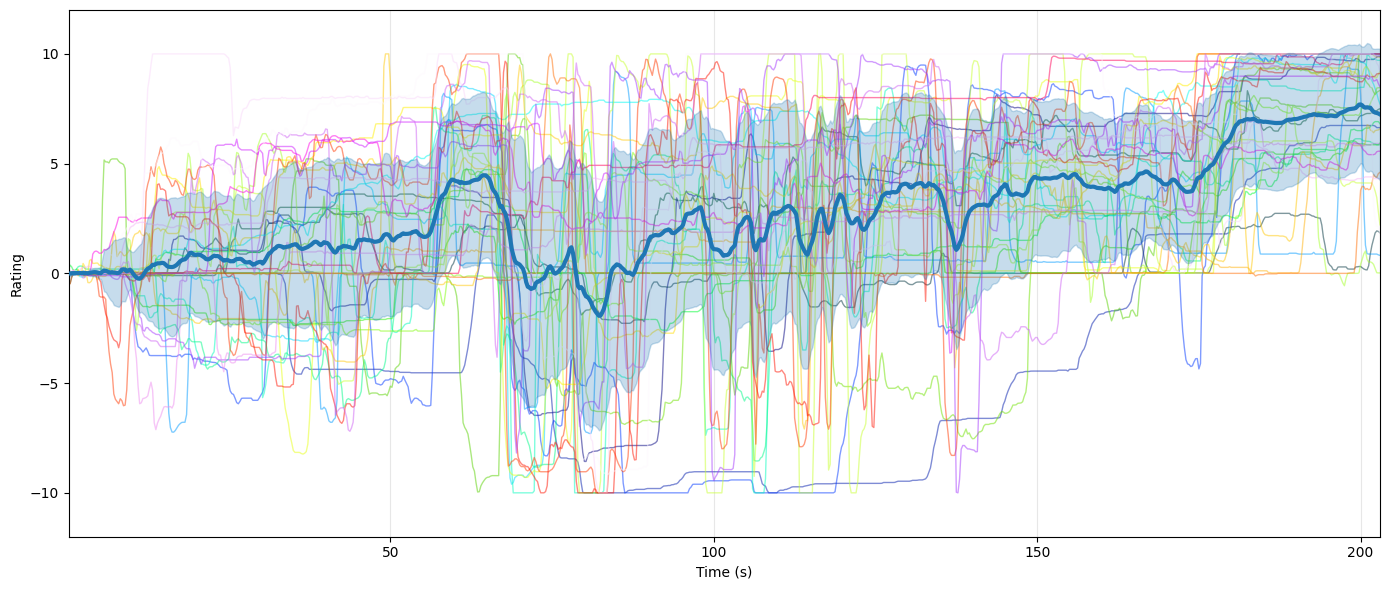

In [59]:
import numpy as np
import matplotlib.pyplot as plt

S, N, D = cube.shape
T_all = cube[:, :, 0].astype(float)
t_ref = T_all[0]
Y_all = cube[:, :, 1].astype(float)
mean_y = np.nanmean(Y_all, axis=0)
std_y  = np.nanstd(Y_all, axis=0, ddof=0)

colors = plt.cm.gist_ncar(np.linspace(0, 1, S))
fig, ax = plt.subplots(figsize=(14, 6))

for i in range(S):
    x = cube[i, :, 0]           # seconds
    y = cube[i, :, 1]           # rating
    ax.plot(x, y, color=colors[i], lw=1.0, alpha=0.5, label=f"S{i+1}")

(line_mean,) = ax.plot(t_ref, mean_y, lw=3.0, zorder=3, label="Mean rating")
ax.fill_between(t_ref, mean_y - std_y, mean_y + std_y,
                color=line_mean.get_color(), alpha=0.25, label="±1 SD", zorder=2)


max_s = float(np.nanmax(cube[:, :, 0]))
ticks = np.arange(0, (int(max_s // 50) + 1) * 50 + 1, 50)
ax.set_xticks(ticks)
ax.set_xlim(x.min(), max_s)

ax.set_ylim(-12, 12)

ax.set_xlabel("Time (s)")
ax.set_ylabel("Rating")
ax.grid(True, axis="x", alpha=0.3)

# ax.legend(ncol=4, fontsize=8, frameon=False, loc="upper right")

fig.tight_layout()
# fig.savefig("ratings_all_subjects_pc.png", dpi=300, bbox_inches="tight") 
plt.show()


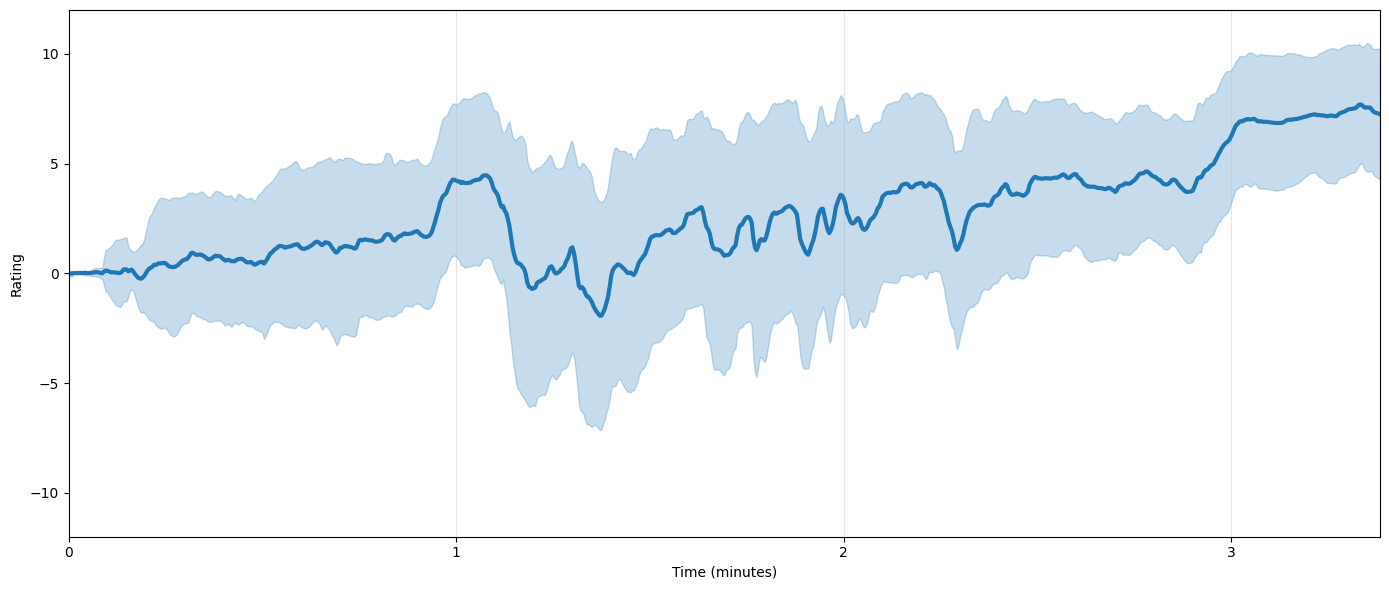

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# cube: (S, N, 2)  [:,:,0]=time in seconds, [:,:,1]=rating
S, N, D = cube.shape
t_sec = cube[0, :, 0].astype(float)         
y_all = cube[:, :, 1].astype(float)          
mean_y = np.nanmean(y_all, axis=0)         
std_y  = np.nanstd(y_all,  axis=0, ddof=0)  

t_min = t_sec / 60.0
t_end_min = float(np.nanmax(t_sec)) / 60.0
xmax_10min = np.ceil(t_end_min / 10.0) * 10.0
xticks = np.arange(0.0, t_end_min)

fig, ax = plt.subplots(figsize=(14, 6))

(line_mean,) = ax.plot(t_min, mean_y, lw=3.0, label="Mean rating")
ax.fill_between(t_min, mean_y - std_y, mean_y + std_y,
                color=line_mean.get_color(), alpha=0.25, label="±1 SD", zorder=0)

ax.set_xlim(t_min[0], t_end_min)
ax.set_xticks(xticks)
ax.set_xlabel("Time (minutes)")
ax.set_ylabel("Rating")
ax.set_ylim(-12, 12)      
ax.grid(True, axis="x", alpha=0.3)
# ax.legend(frameon=False)
fig.savefig("test.png", dpi=300, bbox_inches="tight") 
fig.tight_layout()
plt.show()


# movie_pc

In [37]:
csv_path = "./Movie_ROI/movie_pc/sub-pixar003_ROI114.csv" 
df = pd.read_csv(csv_path)
roi = df.to_numpy(dtype=np.float32).T
print(roi.shape)

root_dir = "./Movie_ROI/movie_pc"
roi_all, subject_ids = load_roi_cube(root_dir)

print("roi_all shape:", roi_all.shape)       
print("num_subjects:", len(subject_ids))
print("first 3 subjects:", subject_ids[:3])


(114, 167)
roi_all shape: (82, 114, 167)
num_subjects: 82
first 3 subjects: ['pixar003', 'pixar005', 'pixar008']


# movie_dm

In [38]:
csv_path = "./Movie_ROI/movie_dm/sub-NDARAE012DGA_ROI114.csv" 
df = pd.read_csv(csv_path)
roi = df.to_numpy(dtype=np.float32).T
print(roi.shape)

root_dir = "./Movie_ROI/movie_dm"
roi_all, subject_ids = load_roi_cube(root_dir)

print("roi_all shape:", roi_all.shape)       
print("num_subjects:", len(subject_ids))
print("first 3 subjects:", subject_ids[:3])


(114, 739)
roi_all shape: (83, 114, 739)
num_subjects: 83
first 3 subjects: ['NDARAE012DGA', 'NDARAG115LZP', 'NDARCG808HDJ']


# Visualization

## Brain Atlas(Schaefer 2018)

In [28]:
# Load the brain atlas labels with additional columns
import pandas as pd

df = pd.read_csv('./atlas/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.Centroid_RAS.csv', skipinitialspace=True)
labels = df[["ROI Label", "ROI Name"]].to_numpy()
coords = df[["R", "A", "S"]].to_numpy(dtype=float) 

split_labels=[]
for label in labels:
    parts = label[1].split('_')[1:]
    if len(parts)==4:
        split_labels.append(parts)
    if len(parts) < 4: # some regions have no name info
        # print('Region name is not explicitly given:', label)
        parts.insert(2, 'roi')
        split_labels.append(parts)

df_1 = pd.DataFrame(split_labels, columns=['Hemisphere', 'Subnetwork', 'Region', 'Parcel index'])
df_2 = pd.DataFrame(
    np.column_stack([labels[:, 0], coords]),
    columns=['ROI ID', 'R', 'A', 'S']
)
df_2['ROI ID'] = df_2['ROI ID'].astype(int)      
df_2[['R','A','S']] = df_2[['R','A','S']].astype(float)

df_atlas = pd.concat([df_1, df_2], axis=1)
df_atlas.reset_index(drop=True, inplace=True)

df_atlas

Hemisphere Subnetwork    Region Parcel index  ROI ID     R     A     S
0          LH        Vis       roi            1       1 -26.0 -34.0 -17.0
1          LH        Vis       roi            2       2 -26.0 -77.0 -14.0
2          LH        Vis       roi            3       3 -17.0 -60.0  -7.0
3          LH        Vis       roi            4       4 -27.0 -95.0  -4.0
4          LH        Vis       roi            5       5  -5.0 -92.0  -2.0
..        ...        ...       ...          ...     ...   ...   ...   ...
95         RH    Default  PFCdPFCm            1      96   7.0  48.0   1.0
96         RH    Default  PFCdPFCm            2      97  11.0  50.0  39.0
97         RH    Default  PFCdPFCm            3      98  26.0  24.0  50.0
98         RH    Default   pCunPCC            1      99  12.0 -54.0  14.0
99         RH    Default   pCunPCC            2     100   7.0 -52.0  31.0

[100 rows x 8 columns]

In [29]:
import re
import numpy as np
import pandas as pd

roi_text = """
ROI # 101: AAL# 37 Hippocampus_L 4101
ROI # 102: AAL# 38 Hippocampus_R 4102
ROI # 103: AAL# 39 ParaHippocampal_L 4111
ROI # 104: AAL# 40 ParaHippocampal_R 4112
ROI # 105: AAL# 41 Amygdala_L 4201
ROI # 106: AAL# 42 Amygdala_R 4202
ROI # 107: AAL# 71 Caudate_L 7001
ROI # 108: AAL# 72 Caudate_R 7002
ROI # 109: AAL# 73 Putamen_L 7011
ROI # 110: AAL# 74 Putamen_R 7012
ROI # 111: AAL# 75 Pallidum_L 7021
ROI # 112: AAL# 76 Pallidum_R 7022
ROI # 113: AAL# 77 Thalamus_L 7101
ROI # 114: AAL# 78 Thalamus_R 7102
""".strip()

# groups: ROI#, AAL#, Region, L/R, AAL code (4101...)
pat = re.compile(r"ROI\s*#\s*(\d+):\s*AAL#\s*(\d+)\s+([A-Za-z]+)_(L|R)\s+(\d+)")

rows1, rows2 = [], []
for line in roi_text.splitlines():
    m = pat.search(line.strip())
    if not m:
        continue
    roi_num, aal_1idx, region, lr, aal_code = m.groups()
    hemi = "LH" if lr == "L" else "RH"

    rows1.append({
        "Hemisphere": hemi,
        "Subnetwork": "AAL",
        "Region": region,
        "Parcel index": pd.NA,                 # 不误用
    })

    rows2.append({
        "ROI ID": int(roi_num),
        "R": np.nan, "A": np.nan, "S": np.nan,
    })

df_1_new = pd.DataFrame(rows1)
df_2_new = pd.DataFrame(rows2)

df_2_new['ROI ID'] = df_2_new['ROI ID'].astype(int)
df_2_new[['R','A','S']] = df_2_new[['R','A','S']].astype(float)
df_1_new['Parcel index'] = df_1_new['Parcel index'].astype('Int64')

new_block = pd.concat([df_1_new.reset_index(drop=True),
                       df_2_new.reset_index(drop=True)], axis=1)

df_atlas = pd.concat([df_atlas, new_block], ignore_index=True)

cols = ['Hemisphere','Subnetwork','Region','Parcel index',
        'ROI ID','R','A','S']
df_atlas = df_atlas.reindex(columns=cols)


In [32]:
df_atlas
df_atlas.to_csv('./atlas/Schaefer2018_114Parcels_7Networks_order_info.csv', index=False)

## subnetwork

In [33]:
df = df_atlas[['Hemisphere', 'Subnetwork', 'ROI ID']]

roi_by_network_hemisphere = {}

grouped = df.groupby(['Subnetwork', 'Hemisphere'])['ROI ID'].apply(list)

for (subnet, hemi), roi_list in grouped.items():
    if subnet not in roi_by_network_hemisphere:
        roi_by_network_hemisphere[subnet] = {}
    roi_by_network_hemisphere[subnet][hemi] = roi_list

from pprint import pprint
pprint(roi_by_network_hemisphere)


{'AAL': {'LH': [101, 103, 105, 107, 109, 111, 113],
         'RH': [102, 104, 106, 108, 110, 112, 114]},
 'Cont': {'LH': [34, 35, 36, 37], 'RH': [81, 82, 83, 84, 85, 86, 87, 88, 89]},
 'Default': {'LH': [38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50],
             'RH': [90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]},
 'DorsAttn': {'LH': [16, 17, 18, 19, 20, 21, 22, 23],
              'RH': [67, 68, 69, 70, 71, 72, 73]},
 'Limbic': {'LH': [31, 32, 33], 'RH': [79, 80]},
 'SalVentAttn': {'LH': [24, 25, 26, 27, 28, 29, 30],
                 'RH': [74, 75, 76, 77, 78]},
 'SomMot': {'LH': [10, 11, 12, 13, 14, 15],
            'RH': [59, 60, 61, 62, 63, 64, 65, 66]},
 'Vis': {'LH': [1, 2, 3, 4, 5, 6, 7, 8, 9],
         'RH': [51, 52, 53, 54, 55, 56, 57, 58]}}


# Pipeline

In [14]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
from scipy import stats
import matplotlib.pyplot as plt


In [4]:
def add_delays(X, n_delays=5):
    """
    Add time delays to stimulus features to model the HRF lag.
    Each delay shifts the feature matrix by 1 TR.

    Parameters
    ----------
    X : array [T, D]
        Original feature matrix.
    n_delays : int
        Number of time delays to include.

    Returns
    -------
    X_all : array [T, D * n_delays]
        Concatenated delayed features.
    """
    delays = [np.roll(X, d, axis=0) for d in range(1, n_delays + 1)]
    X_all = np.concatenate(delays, axis=1)
    X_all[:n_delays, :] = 0  # clear invalid first few TRs
    return X_all

## single feature

In [3]:
def banded_ridge_encoding(roi_data, feature_data, n_subjects,
                          n_delays=5, outer_folds=5, inner_folds=3,
                          num_alphas=30):
    """
    Simplified banded ridge regression for ROI-level encoding model.

    Parameters
    ----------
    roi_data : np.array [n_subjects, n_rois, n_timepoints]
        ROI-level fMRI signals for each subject.
    feature_data : np.array [n_timepoints, n_features]
        External stimulus features aligned with TRs.
    n_subjects : int
        Number of subjects.
    n_delays : int, optional
        Number of time delays to include for HRF modeling.
    outer_folds : int, optional
        Outer-loop folds for model evaluation.
    inner_folds : int, optional
        Inner-loop folds for alpha selection.
    num_alphas : int, optional
        Number of candidate regularization strengths.

    Returns
    -------
    results_r2 : np.array [n_subjects, n_rois]
        Cross-validated R² scores for each subject and ROI.
    """
    alphas = np.logspace(-5, 5, num_alphas)
    results_r2 = np.zeros((n_subjects, roi_data.shape[1]))

    for subj in range(n_subjects):
        print(f"=== Subject {subj+1}/{n_subjects} ===")
        Y = roi_data[subj].T  # [T, ROI]
        X = add_delays(feature_data, n_delays=n_delays)  # [T, D * n_delays]

        # Standardize
        X = StandardScaler().fit_transform(X)
        Y = stats.zscore(Y, axis=0, nan_policy='omit')

        outer_cv = KFold(n_splits=outer_folds, shuffle=False)
        r2_outer = np.zeros((outer_folds, Y.shape[1]))

        for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X)):
            print(f"  Fold {fold+1}/{outer_folds}")

            X_train, X_test = X[train_idx], X[test_idx]
            Y_train, Y_test = Y[train_idx], Y[test_idx]

            inner_cv = KFold(n_splits=inner_folds, shuffle=False)
            ridge = RidgeCV(alphas=alphas, cv=inner_cv)
            ridge.fit(X_train, Y_train)

            Y_pred = ridge.predict(X_test)

            # Compute R² per ROI
            ss_res = np.sum((Y_test - Y_pred)**2, axis=0)
            ss_tot = np.sum((Y_test - np.mean(Y_test, axis=0))**2, axis=0)
            r2 = 1 - ss_res / ss_tot
            r2_outer[fold] = r2

        results_r2[subj] = np.nanmean(r2_outer, axis=0)
        print(f"  Mean R² across ROIs: {np.nanmean(results_r2[subj]):.4f}\n")

    return results_r2


In [11]:
n_subjects = 5
n_rois = 114
n_timepoints = 239
n_features = 50

np.random.seed(42)
roi_data = roi_all
feature_data = np.random.randn(n_timepoints, n_features)

=== Subject 1/5 ===
  Fold 1/5
  Fold 2/5
  Fold 3/5
  Fold 4/5
  Fold 5/5
  Mean R² across ROIs: -0.1299

=== Subject 2/5 ===
  Fold 1/5
  Fold 2/5
  Fold 3/5
  Fold 4/5
  Fold 5/5
  Mean R² across ROIs: -0.0500

=== Subject 3/5 ===
  Fold 1/5
  Fold 2/5
  Fold 3/5
  Fold 4/5
  Fold 5/5
  Mean R² across ROIs: -0.0247

=== Subject 4/5 ===
  Fold 1/5
  Fold 2/5
  Fold 3/5
  Fold 4/5
  Fold 5/5
  Mean R² across ROIs: -0.0110

=== Subject 5/5 ===
  Fold 1/5
  Fold 2/5
  Fold 3/5
  Fold 4/5
  Fold 5/5
  Mean R² across ROIs: -0.0300



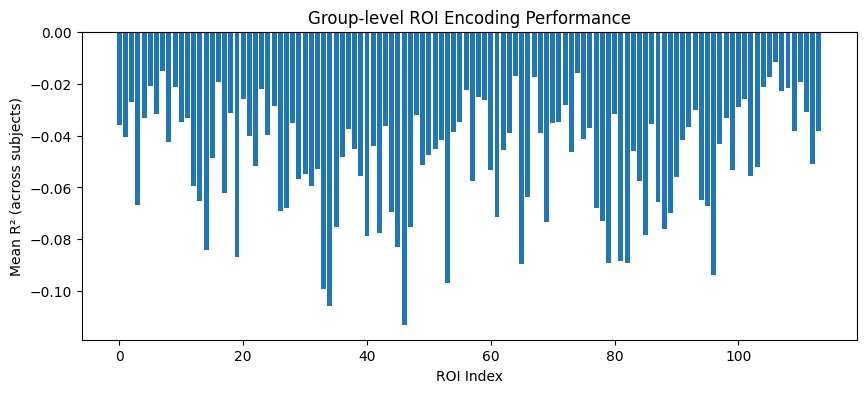

In [12]:
results_r2 = banded_ridge_encoding(
    roi_data, feature_data,
    n_subjects=n_subjects,
    n_delays=5,
    outer_folds=5,
    inner_folds=3
)

group_mean = np.nanmean(results_r2, axis=0)

plt.figure(figsize=(10, 4))
plt.bar(np.arange(len(group_mean)), group_mean)
plt.xlabel("ROI Index")
plt.ylabel("Mean R² (across subjects)")
plt.title("Group-level ROI Encoding Performance")
plt.show()


## joint features

In [15]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from himalaya.kernel_ridge import MultipleKernelRidgeCV, Kernelizer, ColumnKernelizer
from himalaya.backend import set_backend
from scipy import stats
from sklearn.model_selection import GroupKFold
from sklearn.pipeline import make_pipeline
from himalaya.scoring import r2_score_split

In [121]:
def multi_kernel_encoding(roi_data, features_dict,
                          feature_order, n_subjects,
                          n_delays=5, outer_folds=5,
                          num_alphas=30):

    alphas = np.logspace(-5, 5, num_alphas)
    n_rois = roi_data.shape[1]
    n_features_total = len(feature_order)

    results_r2 = np.zeros((n_subjects, n_rois))          # overall R²
    feature_r2s = np.zeros((n_subjects, n_features_total, n_rois))  # per-feature R²

    for subj in range(n_subjects):
        print(f"=== Subject {subj+1}/{n_subjects} ===")
        Y = roi_data[subj].T  # shape [T, ROI]
        Y = stats.zscore(Y, axis=0, nan_policy="omit")

        # ==== Step 1: delay + normalize each feature ====
        delayed_features = []
        feature_dims = []

        for f in feature_order:
            X = features_dict[f]
            # X = add_delays(X, n_delays=n_delays)
            X = StandardScaler().fit_transform(X)
            delayed_features.append(X)
            feature_dims.append(X.shape[1])

        # ==== Step 2: concatenate all features ====
        X_all = np.concatenate(delayed_features, axis=1)
        print(f"X_all shape = {X_all.shape} (sum of {len(feature_order)} features)")

        # ==== Step 3: make slice ranges ====
        start_end = np.concatenate([[0], np.cumsum(feature_dims)])
        slices = [slice(start, end) for start, end in zip(start_end[:-1], start_end[1:])]

        # ==== Step 4: build kernelizer per feature ====
        kernel_tuples = [
            (name, Kernelizer(kernel="linear"), sl)
            for name, sl in zip(feature_order, slices)
        ]
        column_kernelizer = ColumnKernelizer(kernel_tuples)

        # ==== Step 5: outer CV (temporal chunking) ====
        n_samples = Y.shape[0]
        chunk_len = 24
        n_chunks = int(n_samples / chunk_len)
        groups = [i for i in range(n_chunks) for _ in range(chunk_len)]
        if len(groups) < n_samples:
            groups.extend([n_chunks] * (n_samples - len(groups)))

        cv_outer = GroupKFold(n_splits=outer_folds)
        splits = cv_outer.split(np.arange(n_samples), groups=groups)

        # ==== Step 6: define model ====
        mkr = MultipleKernelRidgeCV(
            kernels="precomputed",
            solver="random_search",
            solver_params=dict(
                alphas=alphas,
                local_alpha=True,
                n_iter=50,
                diagonalize_method="svd"
            ),
            cv=splits
        )

        pipeline = make_pipeline(column_kernelizer, mkr)

        # ==== Step 7: fit and score ====
        pipeline.fit(X_all, Y)
        scores = pipeline.score(X_all, Y)
        results_r2[subj] = np.array(scores)

        # per-feature R² decomposition
        Y_pred_split = pipeline.predict(X_all, split=True)
        split_r2 = r2_score_split(Y, Y_pred_split)
        feature_r2s[subj] = np.array(split_r2)

        print(f"  mean R²_total = {np.nanmean(results_r2[subj]):.4f}")
        for i, f in enumerate(feature_order):
            print(f"    {f:<15s} → mean R² = {np.nanmean(feature_r2s[subj, i]):.4f}")

    return results_r2, feature_r2s

### features

#### Tom/Valence/Empathy/num_ppl/face_present

In [90]:
import numpy as np
import pandas as pd

def resample_to_tr(data, t, start_sec=8.0, TR=0.8):

    assert len(t) == len(data), "t and data length not match"
    t = np.asarray(t)
    data = np.asarray(data)

    t_samples = np.arange(start_sec, t[-1] + 1e-9, TR)

    idx = np.searchsorted(t, t_samples, side="right") - 1
    idx = np.clip(idx, 0, len(t) - 1)

    r = pd.Series(data).ffill().bfill().to_numpy()

    return r[idx]


In [91]:
import numpy as np
import pandas as pd

def sample_tom_ratings(csv_path, start_sec=8.0, TR=0.8,
                       time_col="timestamp_sec", rating_col="tom_rating"):
    df = pd.read_csv(csv_path)
    t = df[time_col].to_numpy(dtype=float)
    r = df[rating_col].to_numpy(dtype=float)

    return resample_to_tr(r, t, start_sec, TR).tolist()


In [92]:
import numpy as np

def ratings_per_TR(cube, TR=0.8, start_sec=None, end_sec=None):
    t = np.nanmean(cube[:, :, 0], axis=0)      # (812,)
    r = np.nanmean(cube[:, :, 1], axis=0)      # (812,)

    if start_sec is None:
        start_sec = float(t[0])
    if end_sec is None:
        end_sec = float(t[-1])

    t_samples = np.arange(start_sec, end_sec + 1e-9, TR)
    idx = np.searchsorted(t, t_samples, side="right") - 1
    idx = np.clip(idx, 0, len(t) - 1)

    return r[idx].tolist() 


In [93]:
ratings_empathy = ratings_per_TR(cube, TR=0.8, start_sec=8.0)
print(len(ratings_empathy))

244


In [96]:
ratings_tom = sample_tom_ratings("the_present_tom.csv", start_sec=8.0, TR=0.8)
ratings_valence = sample_tom_ratings("the_present_valence.csv", start_sec=8.0, TR=0.8, rating_col="valence_rating")
num_ppl = sample_tom_ratings("TP_embeddings.csv", start_sec=8.0, TR=0.8, rating_col="num_people")
face_present_or_not = sample_tom_ratings("TP_embeddings.csv", start_sec=8.0, TR=0.8, rating_col="face_present_binary")

print(len(ratings_tom), len(ratings_valence), len(num_ppl), len(face_present_or_not)) # 244, 244

244 244 244 244


#### language - keywords/description

In [105]:
import pandas as pd

def load_four_groups(csv_path):

    df = pd.read_csv(csv_path)
    cols = list(df.columns)
    t = df["timestamp_sec"].to_numpy(dtype=float)
    
    start_desc = cols.index("desc_emb_0")
    start_kw = cols.index("kw_emb_0")
    idx_num = cols.index("num_people")

    desc = df.iloc[:, start_desc:start_kw].to_numpy()
    kw = df.iloc[:, start_kw:idx_num].to_numpy()

    return desc, kw, t


In [106]:
desc, kw, t= load_four_groups("TP_embeddings.csv")
print(desc.shape, kw.shape)

(212, 768) (212, 300)


In [149]:
import numpy as np
import pandas as pd

def resample_embeddings_to_tr(data, t, start_sec=8.0, TR=0.8, method="mean"):
    """
        data : np.ndarray, shape (N, D)
        t    : np.ndarray, shape (N,) 
        start_sec : float             
        TR   : float                  
        method : {"nearest","mean"}    
    return:
        data_tr : np.ndarray, shape (T, D)
    """
    t = np.asarray(t, dtype=float)
    order = np.argsort(t)
    t = t[order]
    data = np.asarray(data)[order]

    keep = t >= start_sec
    t = t[keep]
    data = data[keep]

    t_end = float(t[-1])

    if method == "nearest":
        tr_times = np.arange(start_sec, t_end + 1e-9, TR)
        idx = np.searchsorted(t, tr_times, side="right") - 1
        idx = np.clip(idx, 0, len(t) - 1)

        data_filled = pd.DataFrame(data).ffill().bfill().to_numpy()
        data_tr = data_filled[idx]

    elif method == "mean":
        edges = np.arange(start_sec, t_end + TR, TR)   
        bins = np.digitize(t, edges) - 1             
        T = len(edges) - 1
        D = data.shape[1]
        out = np.empty((T, D), dtype=float); out[:] = np.nan
        for k in range(T):
            m = (bins == k)
            if np.any(m):
                out[k] = data[m].mean(axis=0)

        data_tr = pd.DataFrame(out).ffill().bfill().to_numpy()
    else:
        raise ValueError("method must be 'nearest' or 'mean'.")

    return data_tr


In [155]:
# data1.shape=(N, D1), data2.shape=(N, D2), t.shape=(N,)
desc_emb = resample_embeddings_to_tr(desc, t, start_sec=8.0, TR=0.8, method="mean")
key_word_emb = resample_embeddings_to_tr(kw,   t, start_sec=8.0, TR=0.8, method="mean")

print(desc_emb.shape, key_word_emb.shape)


(244, 768) (244, 300)


#### vision

In [143]:
import pandas as pd

df = pd.read_csv("TP_alexnet_static_features.csv")
rows, cols = df.shape     
print(rows,cols)


212 10346


In [151]:
import re
import pandas as pd
from collections import Counter

cols = pd.read_csv("TP_alexnet_static_features.csv", nrows=0).columns

labels = []
for c in cols:
    m = re.match(r'^(conv_?([1-5])|fc([6-8]))_', c) 
    if m:
        if m.group(2):   # conv
            labels.append(f"conv{m.group(2)}")
        else:            # fc
            labels.append(f"fc{m.group(3)}")

cnt = Counter(labels)

layers = ["conv1","conv2","conv3","conv4","conv5","fc6","fc7"]
for k in layers:
    print(f"{k}: {cnt.get(k, 0)}")


conv1: 64
conv2: 192
conv3: 384
conv4: 256
conv5: 256
fc6: 4096
fc7: 4096


In [152]:
import re
import pandas as pd

def load_first7_layers(csv_path):

    cols = pd.read_csv(csv_path, nrows=0).columns
    pat = re.compile(r'^(conv_?([1-5])|fc([6-8]))_')
    layer_cols = {l: [] for l in layers}

    for c in cols:
        m = pat.match(c)
        if not m:
            continue
        if m.group(2):   # conv
            layer = f"conv{m.group(2)}"
        else:            # fc
            layer = f"fc{m.group(3)}"
        if layer in layer_cols:
            layer_cols[layer].append(c)

    usecols = [c for L in layers for c in layer_cols[L]]
    df = pd.read_csv(csv_path, usecols=usecols)

    arrays = {}
    for L in layers:
        arr = df[layer_cols[L]].to_numpy()
        arrays[L] = arr
        print(f"{L}: {arr.shape}")  

    return arrays

arrays = load_first7_layers("TP_alexnet_static_features.csv")
print(arrays["conv1"].shape, arrays["fc7"].shape)


conv1: (212, 64)
conv2: (212, 192)
conv3: (212, 384)
conv4: (212, 256)
conv5: (212, 256)
fc6: (212, 4096)
fc7: (212, 4096)
(212, 64) (212, 4096)


In [153]:
resampled_arrays = {}
for layer in layers:
    data = arrays[layer]
    data_tr = resample_embeddings_to_tr(data, t, start_sec=8.0, TR=0.8, method="mean")
    resampled_arrays[layer] = data_tr
    print(f"{layer}: {data_tr.shape}")


conv1: (244, 64)
conv2: (244, 192)
conv3: (244, 384)
conv4: (244, 256)
conv5: (244, 256)
fc6: (244, 4096)
fc7: (244, 4096)


In [156]:
resampled_arrays["fc7"].shape

(244, 4096)

### model

In [157]:
import numpy as np

T = 239  # number of timepoints
TR_list = [6,7]
np.random.seed(0)
roi_data = roi_all
lagged_roi = [roi_data[..., lag:] for lag in TR_list]
# dummy_features = {
#     "alexnet_layer5": np.random.randn(T, 512).astype("float32"),   # visual
#     "hubert": np.random.randn(T, 256).astype("float32"),           # audio
#     "sbert": np.random.randn(T, 768).astype("float32"),            # text/semantic
#     "valence": np.random.randn(T, 1).astype("float32")             # emotion rating
# }
TR_n = 1
T = lagged_roi[TR_n].shape[2]
dummy_features = {
    "valence": np.array(ratings_valence[:T]).reshape(-1,1),     
    "tom": np.array(ratings_tom[:T]).reshape(-1,1),          
    "empathy": np.array(ratings_empathy[:T]).reshape(-1,1),
    "num_ppl": np.array(num_ppl[:T]).reshape(-1,1),
    "face_present_or_not": np.array(face_present_or_not[:T]).reshape(-1,1),  
    "description": np.array(desc_emb[:T]),
    "key_word": np.array(key_word_emb[:T]),
    "layer1":np.array(resampled_arrays["conv1"][:T]),
    "layer2":np.array(resampled_arrays["conv2"][:T]),
    "layer3":np.array(resampled_arrays["conv3"][:T]),
    "layer4":np.array(resampled_arrays["conv4"][:T]),
    "layer5":np.array(resampled_arrays["conv5"][:T]),
    "layer6":np.array(resampled_arrays["fc6"][:T]),
    "layer7":np.array(resampled_arrays["fc7"][:T]),
} 

for name, arr in dummy_features.items():
    print(f"{name:15s} → shape {arr.shape}")

valence         → shape (232, 1)
tom             → shape (232, 1)
empathy         → shape (232, 1)
num_ppl         → shape (232, 1)
face_present_or_not → shape (232, 1)
description     → shape (232, 768)
key_word        → shape (232, 300)
layer1          → shape (232, 64)
layer2          → shape (232, 192)
layer3          → shape (232, 384)
layer4          → shape (232, 256)
layer5          → shape (232, 256)
layer6          → shape (232, 4096)
layer7          → shape (232, 4096)


In [158]:
lagged_roi[1].shape[2] # 233 232

232

In [159]:
feature_order = ["valence", "tom", "empathy", "num_ppl", "face_present_or_not", "description", "key_word","layer1","layer2","layer3","layer4","layer5","layer6","layer7"]

results_r2, feature_r2s = multi_kernel_encoding(
    roi_data=lagged_roi[TR_n],            # shape [n_subjects, n_rois, n_timepoints]
    features_dict=dummy_features, # e.g., dict of {feature_name: [T, D_f]}
    feature_order=feature_order,
    n_subjects=5,
    n_delays=0,
    outer_folds=5,
    num_alphas=30
)


=== Subject 1/5 ===
X_all shape = (232, 10417) (sum of 14 features)
[                                        ] 0% | 0.00 sec | 50 random sampling with cv | 

/Users/yiran/miniconda3/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is deprecated and will be removed in 1.9. It has no effect. Leave it to its default value to avoid this warning.
  warnings.warn(


[........................................] 100% | 166.06 sec | 50 random sampling with cv | 
  mean R²_total = 0.4513
    valence         → mean R² = 0.0001
    tom             → mean R² = 0.0004
    empathy         → mean R² = 0.0054
    num_ppl         → mean R² = 0.0006
    face_present_or_not → mean R² = 0.0002
    description     → mean R² = 0.0361
    key_word        → mean R² = 0.0156
    layer1          → mean R² = 0.0149
    layer2          → mean R² = 0.0124
    layer3          → mean R² = 0.0888
    layer4          → mean R² = 0.0256
    layer5          → mean R² = 0.0243
    layer6          → mean R² = 0.0935
    layer7          → mean R² = 0.1336
=== Subject 2/5 ===
X_all shape = (232, 10417) (sum of 14 features)
[                                        ] 0% | 0.00 sec | 50 random sampling with cv | 

/Users/yiran/miniconda3/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is deprecated and will be removed in 1.9. It has no effect. Leave it to its default value to avoid this warning.
  warnings.warn(


[........................................] 100% | 163.15 sec | 50 random sampling with cv | 
  mean R²_total = 0.1572
    valence         → mean R² = 0.0002
    tom             → mean R² = 0.0000
    empathy         → mean R² = 0.0000
    num_ppl         → mean R² = 0.0001
    face_present_or_not → mean R² = 0.0001
    description     → mean R² = 0.0277
    key_word        → mean R² = 0.0096
    layer1          → mean R² = 0.0143
    layer2          → mean R² = 0.0341
    layer3          → mean R² = 0.0208
    layer4          → mean R² = 0.0303
    layer5          → mean R² = 0.0026
    layer6          → mean R² = 0.0019
    layer7          → mean R² = 0.0156
=== Subject 3/5 ===
X_all shape = (232, 10417) (sum of 14 features)
[                                        ] 0% | 0.00 sec | 50 random sampling with cv | 

/Users/yiran/miniconda3/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is deprecated and will be removed in 1.9. It has no effect. Leave it to its default value to avoid this warning.
  warnings.warn(


[........................................] 100% | 169.64 sec | 50 random sampling with cv | 
  mean R²_total = 0.3653
    valence         → mean R² = 0.0002
    tom             → mean R² = 0.0003
    empathy         → mean R² = 0.0015
    num_ppl         → mean R² = 0.0004
    face_present_or_not → mean R² = 0.0002
    description     → mean R² = 0.0382
    key_word        → mean R² = 0.0341
    layer1          → mean R² = 0.0017
    layer2          → mean R² = 0.0059
    layer3          → mean R² = 0.0133
    layer4          → mean R² = 0.0425
    layer5          → mean R² = 0.0112
    layer6          → mean R² = 0.1062
    layer7          → mean R² = 0.1097
=== Subject 4/5 ===
X_all shape = (232, 10417) (sum of 14 features)
[                                        ] 0% | 0.00 sec | 50 random sampling with cv | 

/Users/yiran/miniconda3/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is deprecated and will be removed in 1.9. It has no effect. Leave it to its default value to avoid this warning.
  warnings.warn(


[........................................] 100% | 160.16 sec | 50 random sampling with cv | 
  mean R²_total = 0.3923
    valence         → mean R² = 0.0001
    tom             → mean R² = 0.0001
    empathy         → mean R² = 0.0003
    num_ppl         → mean R² = 0.0006
    face_present_or_not → mean R² = 0.0001
    description     → mean R² = 0.0193
    key_word        → mean R² = 0.0571
    layer1          → mean R² = 0.0332
    layer2          → mean R² = 0.0472
    layer3          → mean R² = 0.0283
    layer4          → mean R² = 0.0190
    layer5          → mean R² = 0.0618
    layer6          → mean R² = 0.0320
    layer7          → mean R² = 0.0932
=== Subject 5/5 ===
X_all shape = (232, 10417) (sum of 14 features)
[                                        ] 0% | 0.00 sec | 50 random sampling with cv | 

/Users/yiran/miniconda3/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:975: FutureWarning: The parameter `force_int_remainder_cols` is deprecated and will be removed in 1.9. It has no effect. Leave it to its default value to avoid this warning.
  warnings.warn(


[........................................] 100% | 160.37 sec | 50 random sampling with cv | 
  mean R²_total = 0.1761
    valence         → mean R² = 0.0000
    tom             → mean R² = 0.0001
    empathy         → mean R² = 0.0001
    num_ppl         → mean R² = 0.0002
    face_present_or_not → mean R² = 0.0001
    description     → mean R² = 0.0432
    key_word        → mean R² = 0.0042
    layer1          → mean R² = 0.0032
    layer2          → mean R² = 0.0071
    layer3          → mean R² = 0.0161
    layer4          → mean R² = 0.0116
    layer5          → mean R² = 0.0086
    layer6          → mean R² = 0.0591
    layer7          → mean R² = 0.0224


In [123]:
feature_r2s.shape

(5, 7, 114)

In [124]:
results_r2.shape

(5, 114)

In [125]:
np.nanmean(np.nanmean(results_r2, axis=1))

0.07737831488329869

In [126]:
np.nanmean(np.nanmean(feature_r2s[0], axis=1))

0.020737270110732498

In [127]:
np.nanmean(np.nanmean(feature_r2s[1], axis=1))

0.005788592637097386

In [128]:
np.nanmean(np.nanmean(feature_r2s[2], axis=1))

0.012671404529310948

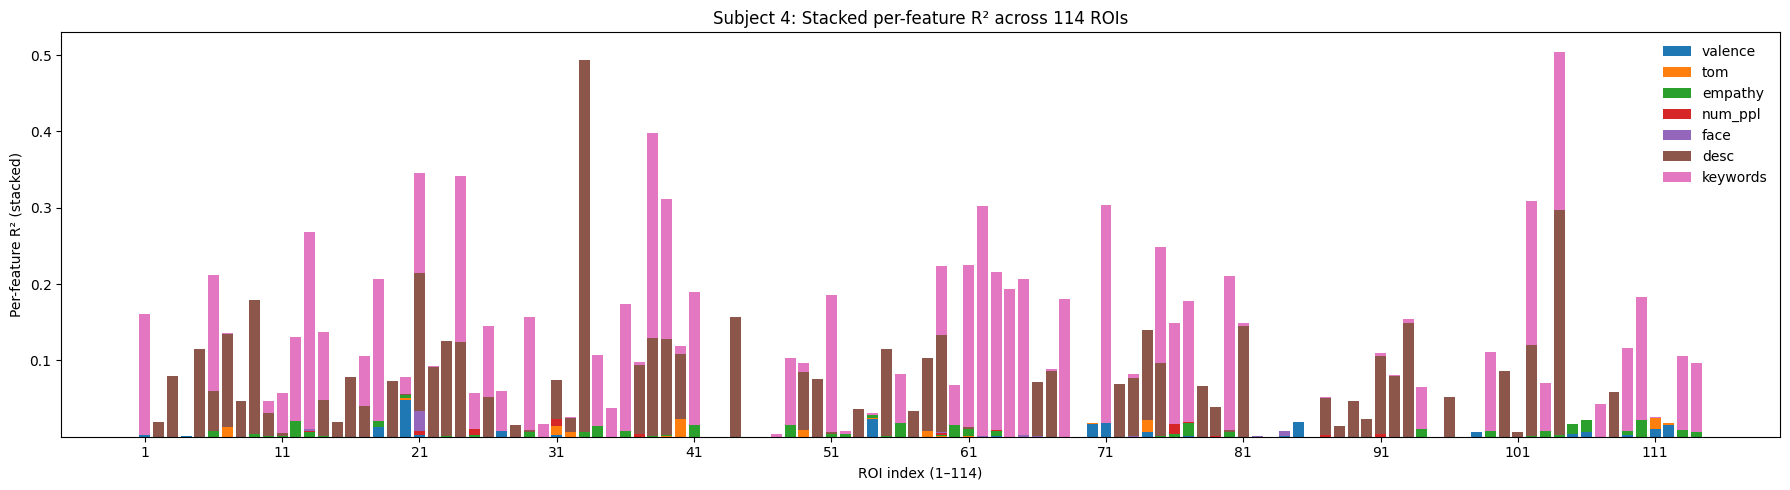

In [146]:
import numpy as np
import matplotlib.pyplot as plt

# Prepare data (use user's variable if available; otherwise demo)
demo_used = False
try:
    feature_r2s  # noqa: F821
except NameError:
    demo_used = True
    rng = np.random.default_rng(0)
    feature_r2s = rng.uniform(0, 0.05, size=(5, 7, 114)).astype(float)

# Subject 1 (index 0)
subj_idx = 3
data = feature_r2s[subj_idx]  # (7, 114)

# Ensure correct shape
data = data[:, :114]
rois = np.arange(1, data.shape[1] + 1)
labels = ["valence", "tom", "empathy", "num_ppl", "face", "desc", "keywords"]

# Plot stacked bars
plt.figure(figsize=(18, 5))
bottom = np.zeros(data.shape[1])
for i in range(7):
    plt.bar(rois, data[i], bottom=bottom, label=labels[i])
    bottom += data[i]

plt.xlabel("ROI index (1–114)")
plt.ylabel("Per-feature R² (stacked)")
plt.title("Subject 4: Stacked per-feature R² across 114 ROIs")
tick_step = 10 if data.shape[1] >= 50 else 1
plt.xticks(np.arange(1, data.shape[1] + 1, tick_step))
plt.legend(loc="upper right", frameon=False)
plt.tight_layout()
plt.savefig("1.png")
plt.show()

if demo_used:
    print("NOTE: Using demo random data because `feature_r2s` was not found. Replace with your real array in the environment.")


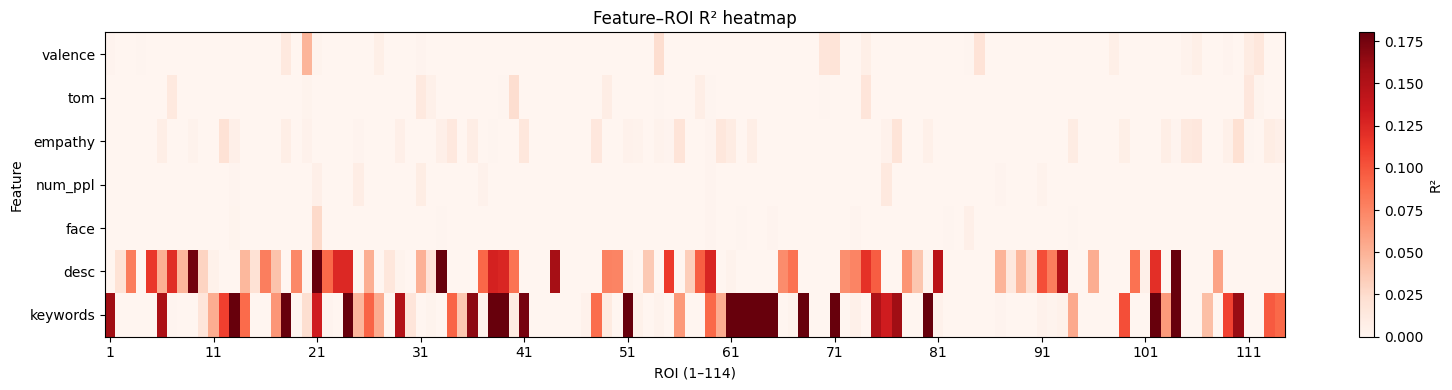

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# data: shape (7, 114)

features = ["valence", "tom", "empathy", "num_ppl", "face", "desc", "keywords"]
vmin = np.nanpercentile(data, 2)  
vmax = np.nanpercentile(data, 98)  

cmap = plt.cm.Reds.copy()
cmap.set_bad(color="lightgray")
masked = np.ma.masked_invalid(data)

plt.figure(figsize=(16, 4))
im = plt.imshow(masked, aspect="auto", interpolation="nearest",
                vmin=vmin, vmax=vmax, cmap=cmap)

plt.xlabel("ROI (1–114)")
plt.ylabel("Feature")
plt.yticks(ticks=np.arange(data.shape[0]), labels=features[:data.shape[0]])

step = 10
xticks = np.arange(0, data.shape[1], step)
plt.xticks(xticks, xticks + 1) 

cbar = plt.colorbar(im)
cbar.set_label("R²")

plt.title("Feature–ROI R² heatmap")
plt.tight_layout()
plt.savefig("2.png")



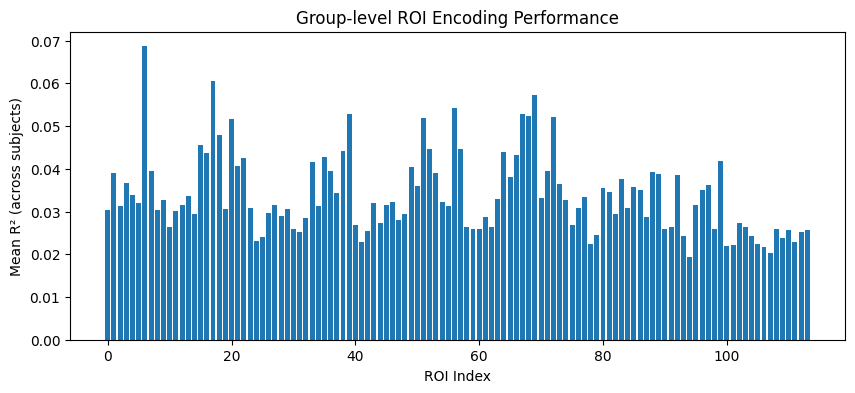

In [58]:
group_mean = np.nanmean(results_r2, axis=0)

plt.figure(figsize=(10, 4))
plt.bar(np.arange(len(group_mean)), group_mean)
plt.xlabel("ROI Index")
plt.ylabel("Mean R² (across subjects)")
plt.title("Group-level ROI Encoding Performance")
plt.show()